# Decision Networks

I guess you remember the Bayesian network of our diabetes problem. Let us turn this network into a simple **decision network** to give diet suggestions to a person based on her/his most recent medical exams. As usual, let us load some libraries.

In [1]:
import networkx as nx # for drawing graphs
import matplotlib.pyplot as plt # for drawing graphs
import pandas as pd
import numpy as np

# for creating Bayesian Belief Networks (BBN)
from pybbn.graph.dag import Bbn
from pybbn.graph.edge import Edge, EdgeType
from pybbn.graph.jointree import EvidenceBuilder
from pybbn.graph.node import BbnNode
from pybbn.graph.variable import Variable
from pybbn.pptc.inferencecontroller import InferenceController

Now we load our already known diabetes database.

In [2]:
diabetes = pd.read_csv('diabetes-dataset.csv')
diabetes.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,2,138,62,35,0,33.6,0.127,47,1
1,0,84,82,31,125,38.2,0.233,23,0
2,0,145,0,0,0,44.2,0.630,31,1
3,0,135,68,42,250,42.3,0.365,24,1
4,1,139,62,41,480,40.7,0.536,21,0


Let us add the `Overweight` column to the dataframe.

In [3]:
diabetes['Overweight'] = 0
diabetes.loc[diabetes['BMI'] > 25, 'Overweight'] = 1
diabetes

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,Overweight
0,2,138,62,35,0,33.6,0.127,47,1,1
1,0,84,82,31,125,38.2,0.233,23,0,1
2,0,145,0,0,0,44.2,0.630,31,1,1
3,0,135,68,42,250,42.3,0.365,24,1,1
4,1,139,62,41,480,40.7,0.536,21,0,1
...,...,...,...,...,...,...,...,...,...,...
1995,2,75,64,24,55,29.7,0.370,33,0,1
1996,8,179,72,42,130,32.7,0.719,36,1,1
1997,6,85,78,0,0,31.2,0.382,42,0,1
1998,0,129,110,46,130,67.1,0.319,26,1,1


As you might guess, we will use a function to discretize the continuous variables of this dataset using quartiles.

In [5]:
df = discretize(diabetes)
df

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,Overweight
0,1,2,0,2,0,2,0,3,1,1
1,0,0,3,2,1,3,0,0,0,1
2,0,3,0,0,0,3,3,2,1,1
3,0,2,1,3,3,3,1,1,1,1
4,0,2,0,3,3,3,2,0,0,1
...,...,...,...,...,...,...,...,...,...,...
1995,1,0,1,1,0,1,1,2,0,1
1996,3,3,2,3,2,2,3,2,1,1
1997,3,0,2,0,0,1,2,3,0,1
1998,0,2,3,3,2,3,1,1,1,1


We also need to encode the topology of the Bayesian network and know what values, after discretization, each node of the network migh take. This is done with the following two dictionaries, which are going to be helpful to obtain the tables of each node of the graph.

In [6]:
graph = {'Overweight': [], 
         'DiabetesPedigreeFunction': [], 
         'Age': [], 
         'Pregnancies': [],
         'SkinThickness' : ['Overweight'], 
         'BMI': ['Overweight'],
         'Outcome': ['Overweight', 'DiabetesPedigreeFunction', 'Age', 'Pregnancies'],
         'BloodPressure': ['Overweight', 'Outcome'],
         'Insulin': ['Outcome'],
         'Glucose': ['Outcome']}

values = {'Overweight': [0, 1], 
          'DiabetesPedigreeFunction': [0, 1, 2, 3], 
          'Age': [0, 1, 2, 3], 
          'Pregnancies': [0, 1, 2, 3],
          'SkinThickness' : [0, 1, 2, 3], 
          'BMI': [0, 1, 2, 3],
          'Outcome': [0, 1],
          'BloodPressure': [0, 1, 2, 3],
          'Insulin': [0, 1, 2, 3],
          'Glucose': [0, 1, 2, 3]}

The following function takes a number in base 10 and convert it into a number in a different base and with a arbitrary number of digits. This is just useful for the implementation that was coded for obtaining the tables of each node of the Bayesian network. 

In [7]:
def new_base(n, digits, base):
    
    number = digits * [0]
    
    for i in range(digits-1, -1, -1):
        number[i] = int((n / base ** (digits - i - 1)) % base)
    
    return number

This function does the "heavylifting" to the table of a given node of the Bayesian network. It receives as parameters the two dictionaries that were defined above, the name of the node we are intereste in, and the disretized dataframe.

This is the main function that delivers the bales for each node of the Bayesian network. It basically calls in a for loop the above function and returns a dictionary that contains all the tables that are needed for definig the nodes of the network using `pybnn`.

In [9]:
def tables(df, graph, values):
    
    probabilities_tables = {}
    
    for node in df.columns:
        probabilities_tables[node] = probabilities(df, node, graph, values)
    
    return probabilities_tables   

In [10]:
tables_network = tables(df, graph, values)

Now we create the nodes of the Bayesian network and their corresponding conditional probability tables. 

In [11]:
overweight = BbnNode(Variable(0, 'OW', ['0', '1']), tables_network['Overweight'])
dfp = BbnNode(Variable(1, 'DPF', ['0', '1', '2', '3']), tables_network['DiabetesPedigreeFunction'])
age = BbnNode(Variable(2, 'Age', ['0', '1', '2', '3']), tables_network['Age'])
pregnancies = BbnNode(Variable(3, 'Preg.', ['0', '1', '2', '3']), tables_network['Pregnancies'])
skin = BbnNode(Variable(4, 'Skin', ['0', '1', '2', '3']), tables_network['SkinThickness'])
bmi = BbnNode(Variable(5, 'BMI', ['0', '1', '2', '3']), tables_network['BMI'])
diabetes = BbnNode(Variable(6, 'Diabetes', ['0', '1']), tables_network['Outcome'])
bp = BbnNode(Variable(7, 'BP', ['0', '1', '2', '3']), tables_network['BloodPressure'])
insulin = BbnNode(Variable(8, 'Insulin', ['0', '1', '2', '3']), tables_network['Insulin'])
glucose = BbnNode(Variable(9, 'Glucose', ['0', '1', '2', '3']), tables_network['Glucose'])

Now we can create an object for our graph. We need to specify which objects are going to be the nodes and we also need to specify how these are going to be connected. Further, we need to define another object, `join_tree`, which is the one we will use to compute the probabilities of some events given a certain evidence. 

In [12]:
bbn = Bbn() \
    .add_node(overweight) \
    .add_node(dfp) \
    .add_node(age) \
    .add_node(pregnancies) \
    .add_node(skin) \
    .add_node(bmi) \
    .add_node(diabetes) \
    .add_node(bp) \
    .add_node(insulin) \
    .add_node(glucose) \
    .add_edge(Edge(overweight, skin, EdgeType.DIRECTED)) \
    .add_edge(Edge(overweight, bmi, EdgeType.DIRECTED)) \
    .add_edge(Edge(overweight, bp, EdgeType.DIRECTED)) \
    .add_edge(Edge(overweight, diabetes, EdgeType.DIRECTED)) \
    .add_edge(Edge(dfp, diabetes, EdgeType.DIRECTED)) \
    .add_edge(Edge(age, diabetes, EdgeType.DIRECTED)) \
    .add_edge(Edge(pregnancies, diabetes, EdgeType.DIRECTED)) \
    .add_edge(Edge(diabetes, bp,EdgeType.DIRECTED)) \
    .add_edge(Edge(diabetes, insulin,EdgeType.DIRECTED)) \
    .add_edge(Edge(diabetes, glucose,EdgeType.DIRECTED)) \

# Convert the BBN to a join tree
join_tree = InferenceController.apply(bbn)

I find the following lines of code useful because by seeing an image of the graph we just created we can visualize if we defined our Bayesian network correclty. This is particularly useful for more complex networks than the one we just implemented. 

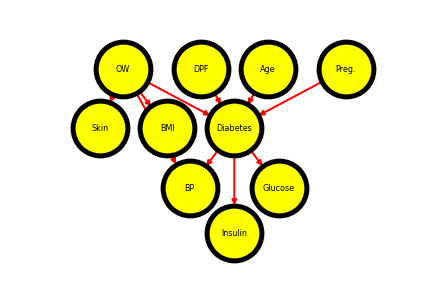

In [13]:
# Set node positions
pos = {0: (-5000, 20000), 1: (-1500, 20000), 2: (1500, 20000), 3: (5000, 20000), 4: (-6000, 0), 5: (-3000, 0), 6: (0, 0), 7: (-2000, -20000), 8: (0, -35000), 9: (2000, -20000)}

# Set options for graph looks
options = {"font_size" : 8, "node_size" : 3000, "node_color" : "yellow", 
           "edgecolors" : "black", "edge_color" : "red", "linewidths" : 5, 
           "width": 2}
    
# Generate graph
n, d = bbn.to_nx_graph()
nx.draw(n, with_labels=True, labels=d, pos=pos, **options)

# Update margins and print the graph
ax = plt.gca()
ax.margins(0.3)
plt.axis("off")
plt.show()

The following function is not completely necessary, but it is useful for printing out the current probabilities of the nodes of our network. You will see that it will be used kind of often.

In [14]:
# Define a function for printing marginal probabilities
# Use this function for project of the week.
def print_probs():
    for node in join_tree.get_bbn_nodes():
        potential = join_tree.get_bbn_potential(node)
        print("Node:", node)
        print("Values:")
        print(potential)
        print('----------------')
    
# Use the above function to print marginal probabilities
print_probs()

Node: 0|OW|0,1
Values:
0=0|0.15300
0=1|0.84700
----------------
Node: 4|Skin|0,1,2,3
Values:
4=0|0.45900
4=1|0.16650
4=2|0.17750
4=3|0.19700
----------------
Node: 5|BMI|0,1,2,3
Values:
5=0|0.25650
5=1|0.24700
5=2|0.24550
5=3|0.25100
----------------
Node: 6|Diabetes|0,1
Values:
6=0|0.64328
6=1|0.35672
----------------
Node: 8|Insulin|0,1,2,3
Values:
8=0|0.60692
8=1|0.12857
8=2|0.13027
8=3|0.13424
----------------
Node: 9|Glucose|0,1,2,3
Values:
9=0|0.23164
9=1|0.25341
9=2|0.25548
9=3|0.25947
----------------
Node: 7|BP|0,1,2,3
Values:
7=0|0.24916
7=1|0.23093
7=2|0.25878
7=3|0.26112
----------------
Node: 1|DPF|0,1,2,3
Values:
1=0|0.24850
1=1|0.25100
1=2|0.24950
1=3|0.25100
----------------
Node: 2|Age|0,1,2,3
Values:
2=0|0.23050
2=1|0.25950
2=2|0.24700
2=3|0.26300
----------------
Node: 3|Preg.|0,1,2,3
Values:
3=0|0.32850
3=1|0.23950
3=2|0.16600
3=3|0.26600
----------------


The function `evidence` is not necessary either, however, as you can see, we need to write some lines of code to "add" evidence to our model. This information is used to update the probabilities of the distributions of each node of the Bayesian network. Since this piece of code will be used often it is better to encapsulate these lines within a function.

In [15]:
# To add evidence of events that happened so probability distribution can be recalculated
def evidence(ev, nod, cat, val):
    ev = EvidenceBuilder() \
    .with_node(join_tree.get_bbn_node_by_name(nod)) \
    .with_evidence(cat, val) \
    .build()
    join_tree.set_observation(ev)

Now we can define easily the events we know took place with the function we defined above.

In [16]:
# Use above function to add evidence
evidence('ev1', 'Glucose', '3', 1)
evidence('ev2', 'DPF', '2', 1)

# Print marginal probabilities
print_probs()

Node: 0|OW|0,1
Values:
0=0|0.13455
0=1|0.86545
----------------
Node: 4|Skin|0,1,2,3
Values:
4=0|0.45049
4=1|0.16764
4=2|0.18073
4=3|0.20115
----------------
Node: 5|BMI|0,1,2,3
Values:
5=0|0.24031
5=1|0.25238
5=2|0.25085
5=3|0.25647
----------------
Node: 6|Diabetes|0,1
Values:
6=0|0.32824
6=1|0.67176
----------------
Node: 8|Insulin|0,1,2,3
Values:
8=0|0.57317
8=1|0.10856
8=2|0.15740
8=3|0.16086
----------------
Node: 9|Glucose|0,1,2,3
Values:
9=0|0.00000
9=1|0.00000
9=2|0.00000
9=3|1.00000
----------------
Node: 7|BP|0,1,2,3
Values:
7=0|0.22126
7=1|0.21868
7=2|0.27076
7=3|0.28930
----------------
Node: 1|DPF|0,1,2,3
Values:
1=0|0.00000
1=1|0.00000
1=2|1.00000
1=3|0.00000
----------------
Node: 2|Age|0,1,2,3
Values:
2=0|0.18818
2=1|0.19231
2=2|0.23882
2=3|0.38069
----------------
Node: 3|Preg.|0,1,2,3
Values:
3=0|0.29497
3=1|0.25714
3=2|0.16849
3=3|0.27940
----------------


If you need to reset the Bayesian network, rerun this line of code or rerun the above cell twice.

In [ ]:
join_tree = InferenceController.apply(bbn)

## Project of the week

We are going to help a to person choose a certain food based on their **glycemic index** (GI), which is a number between 0 and 100, being pure glucose a food with a glycemic index of one hundred. Based on this index, foods are divided into three categories: *low GI* ($GI<55$), *medium GI* ($55\leq GI\leq69$), and *high GI* ($GI\geq70$). 

In order to do this, we will add a decision node and a utility node to the Bayesian network. For the decision node, we will have three actions: pick either a low GI food, a medium GI food, or a high GI food. As for the utility node, we have the following utility table:

![](utility.png)

As we can see the `Diabetes` node is a parent of the utility node. 

Your mission is to, given some evidence, help a person to choose their food among the available three options. As expected, this choice will be determined by the principle of **Maximum Expected Utility**.